In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
import numpy as np
import pandas as pd
#import os
import json
#import re
import matplotlib
import matplotlib.pyplot as plt
#from matplotlib.patches import ConnectionPatch
#import plotly.express as px
#import plotly.figure_factory as ff
#import pycountry
#import copy
import seaborn as sns
from pandas_profiling import ProfileReport
from collections import Counter
from matplotlib import style
#from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

import findspark
findspark.init()
from pyspark.sql import *

spark = SparkSession.builder.master("local[*]").getOrCreate()

Mounted at /content/drive


In [ ]:
#style.use("ggplot")
#drive.mount('/content/gdrive',force_remount=True)
#base_dir = 'gdrive/My Drive/EDA_Big_Data_Dataset/'


In [ ]:
docs=[]
counts=0
drive.mount('/content/gdrive',force_remount=True)
path = 'gdrive/My Drive/EDA_Big_Data_Dataset/'
dirs = os.listdir(path)

# This would print all the files and directories
for file in dirs:
  #print(file)
  file_path = f"/content/gdrive/My Drive/EDA_Big_Data_Dataset/{file}"
  j = json.load(open(file_path,"rb"))
  #Taking last 7 characters. it removes the 'PMC' appended to the beginning
  #also paperid in pdf_json are guids and hard to plot in the graphs hence the substring
  paper_id = j['paper_id']
  paper_id = paper_id[-7:]
  title = j['metadata']['title']
  try:#sometimes there are no abstracts
    abstract = j['abstract'][0]['text']
  except:
    abstract = ""
  full_text = ""
  bib_entries = []
  for text in j['body_text']:
    full_text += text['text']
    for csp in text['cite_spans']:
      try:
        title = j['bib_entries'][csp['ref_id']]['title']
        bib_entries.append(title)
      except:
        pass        
  docs.append([paper_id, title, abstract, full_text, bib_entries])
  counts = counts + 1
  if(counts >= 10000):
    break   
df=pd.DataFrame(docs,columns=['paper_id','title','abstract','full_text','bib_entries']) 
df_sp = spark.createDataFrame(df)

Mounted at /content/gdrive


In [ ]:
print(df_sp)
df_sp.show(10)
df_sp.head(10)

DataFrame[paper_id: string, title: string, abstract: string, full_text: string, bib_entries: array<string>]
+--------+--------------------+--------------------+--------------------+--------------------+
|paper_id|               title|            abstract|           full_text|         bib_entries|
+--------+--------------------+--------------------+--------------------+--------------------+
| 8d11bbb|Submit your next ...|Background: Médec...|Médecins Sans Fro...|[Innovation médic...|
| 141ea7b|Viral infection i...|Of 7,772 laborato...|The human respira...|[Respiratory sync...|
| a290117|A critical role o...|Background: Vario...|Plasmodium falcip...|[The pathogenic b...|
| 35452b9|Implementation of...|The smallest know...|In contrast to th...|[Evolutionary pri...|
| 9eff92d|FDA draft guidanc...|                    |Two pathways are ...|[FDA guidance for...|
| f2845f7|Full Title: A sys...|                    |Since the first h...|                  []|
| 3e2fa78|Supplementary Inf...|      

[Row(paper_id='8d11bbb', title='Submit your next manuscript to BioMed Central and take full advantage of: • Convenient online submission • Thorough peer review • No space constraints or color figure charges • Immediate publication on acceptance • Inclusion in PubMed, CAS, Scopus and Google Scholar • Research which is freely available for redistribution', abstract="Background: Médecins Sans Frontières (MSF) is one of the world's leading humanitarian medical organizations. The increased emphasis in MSF on research led to the creation of an ethics review board (ERB) in 2001. The ERB has encouraged innovation in the review of proposals and the interaction between the ERB and the organization. This has led to some of the advances in ethics governance described in this paper. Discussion: We first update our previous work from 2009 describing ERB performance and then highlight five innovative practices:", full_text='Médecins Sans Frontières (MSF) is one of the world\'s leading humanitarian me

In [ ]:
df_abstract = df.loc[df['abstract'] != '']
with pd.option_context('display.max_colwidth', -1):
    display(df_abstract[['paper_id','title','abstract','bib_entries']].head(2))

,paper_id,title,abstract,bib_entries
0,8d11bbb,"Submit your next manuscript to BioMed Central and take full advantage of: • Convenient online submission • Thorough peer review • No space constraints or color figure charges • Immediate publication on acceptance • Inclusion in PubMed, CAS, Scopus and Google Scholar • Research which is freely available for redistribution",Background: Médecins Sans Frontières (MSF) is one of the world's leading humanitarian medical organizations. The increased emphasis in MSF on research led to the creation of an ethics review board (ERB) in 2001. The ERB has encouraged innovation in the review of proposals and the interaction between the ERB and the organization. This has led to some of the advances in ethics governance described in this paper. Discussion: We first update our previous work from 2009 describing ERB performance and then highlight five innovative practices:,"[Innovation médicales en situations humanitaires: le travail de Médecins Sans Frontières, Conducting operational research within a non governmental organization: the example of Médecins Sans Frontières, Research ethics review in humanitarian contexts: the experience of the independent ethics review board of Medecins Sans Frontieres, Research ethics review in humanitarian contexts: the experience of the independent ethics review board of Medecins Sans Frontieres, What makes clinical research in developing countries ethical? The benchmarks of ethical research, MSF Field research, World Medical Association Declaration of Helsinki. Ethical Principles for Medical Research Involving Human Subjects, Council for International Organizations of Medical Sciences (CIOMS) in collaboration with the World Health Organization (WHO), Council for International Organizations of Medical Sciences (CIOMS) in collaboration with the World Health Organization (WHO), World Medical Association Declaration of Helsinki. Ethical Principles for Medical Research Involving Human Subjects, Theory and practice in public health ethics: a complex relationship, Relief of oppression': an organizing principle for researchers' obligations to participants in observational studies in the developing world, A framework for ethics review during public emergencies, Research ethics governance in disaster situations, Research in complex humanitarian emergencies: the médecins sans frontières/epicentre experience, Research ethics and international epidemic response: the case of Ebola and Marburg hemorrhagic fevers, World Medical Association Declaration of Helsinki. Ethical Principles for Medical Research Involving Human Subjects, Council for International Organizations of Medical Sciences (CIOMS) in collaboration with the World Health Organization (WHO), Making an Impact: A Preferred Framework and Indicators to Measure Returns on Investment in Health Research, What is the purpose of medical research?, Is operational research delivering the goods? The journey to success in low-income countries, Making sure that clinical trial results make a difference: operational research and the hierarchy of evidence, Nifurtimox-eflornithine combination therapy for second-stage Trypanosoma brucei gambiense sleeping sickness: a randomized clinical trial in Congo, Mental health treatment outcomes in a humanitarian emergency: a pilot model for the integration of mental health into primary care in Habilla, Practicing medicine without borders: tele-consultations and tele-mentoring for improving paediatric care in a conflict setting in Somalia, Treating 4,000 diabetic patients in Cambodia, a high-prevalence but resource-limited setting: a 5-year study, Low referral completion of rapid diagnostic test-negative patients in community-based treatment of malaria in Sierra Leone, Cesarean section rates and indications in sub-Saharan Africa: a multi-country study from Medecins sans Frontieres, Efficacy of three artemisinin combination therapies for the treatmentof uncomplicated Plasmodium falciparum malaria

In [ ]:
def countOccurences(str, targets, paperkey):
  target=[]
  dictonary={}
  dictonary[paperkey] = {} 
  target=targets
  a=str.split(" ")
  count=0
  for targetword in target:
    for i in range(0,len(a)):
      if(targetword==a[i]):
        count=count+1
    #print(paperkey,count)
    dictonary[paperkey]['paper_id']=paperkey
    dictonary[paperkey][targetword]=count
    #print(dictonary)
    count=0
  return dictonary

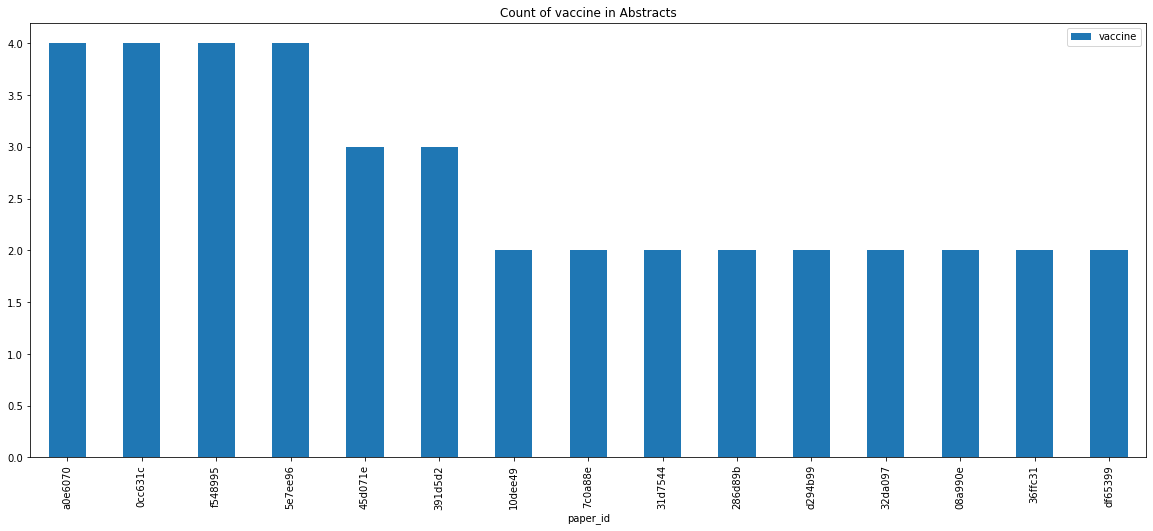

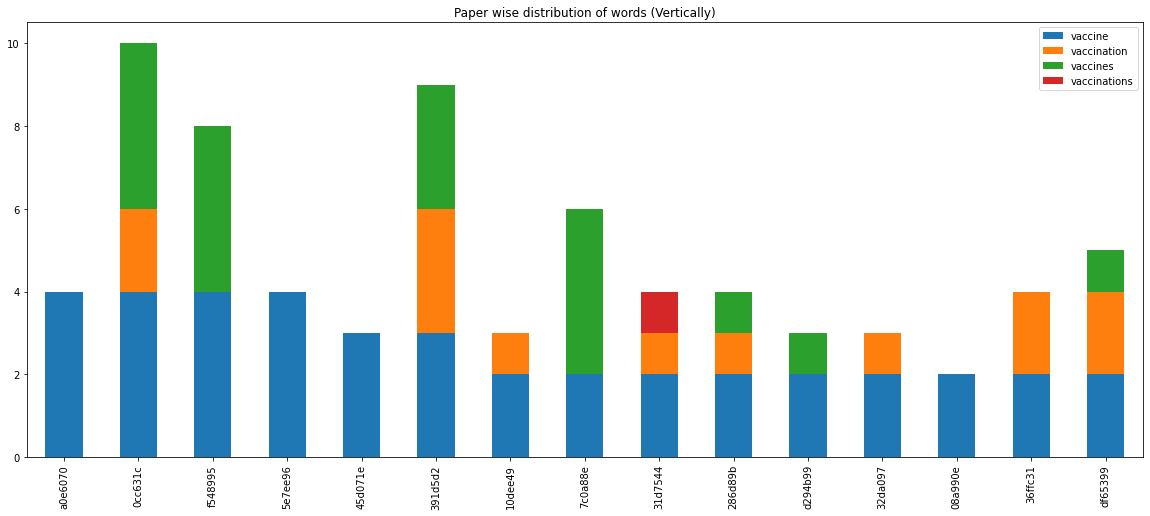

In [ ]:
targets = ['vaccine','vaccination','vaccines','vaccinations'] 
a={}
for line,paperid in df_sp.select("abstract","paper_id").toLocalIterator():
  b=countOccurences(line,targets,paperid)
  a.update(b)
#print(a)
df2=pd.DataFrame(a)
df2=df2.transpose()
#abstract_dataframe_spark=spark.createDataFrame(df2)
#print('Count of Targeted Words in an Abstract')
#abstract_dataframe_spark.sort('vaccine', ascending=False).show(40,False)

temp_df=df2.sort_values(by=['vaccine'],ascending=False)
temp_df=temp_df.head(15)
#print(temp_df)

%matplotlib inline
temp_df.plot(kind='bar',x='paper_id',y='vaccine',figsize=(20,8),title='Count of vaccine in Abstracts')
temp_df.plot(kind='bar',figsize=(20,8),title='Paper wise distribution of words (Vertically)',stacked=True)
#temp_df.plot.barh(figsize=(20,8),title='Paper wise distribution of words (Horizantally)',stacked=True)

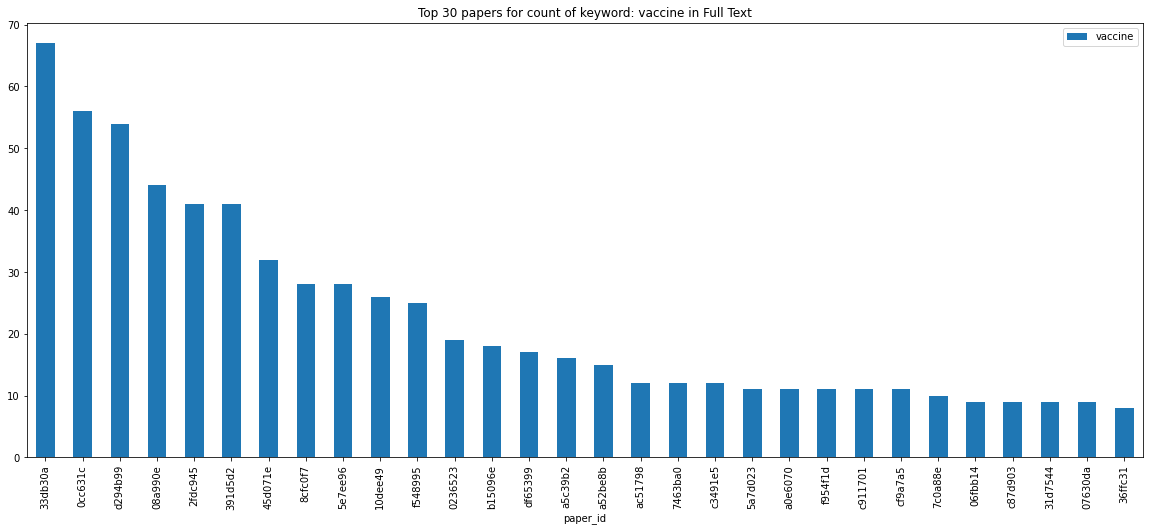

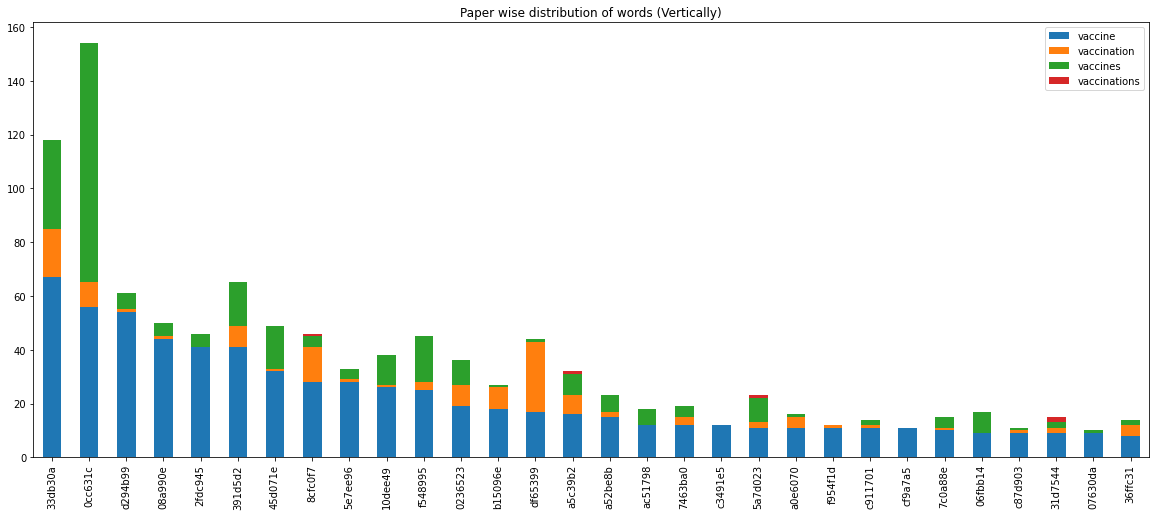

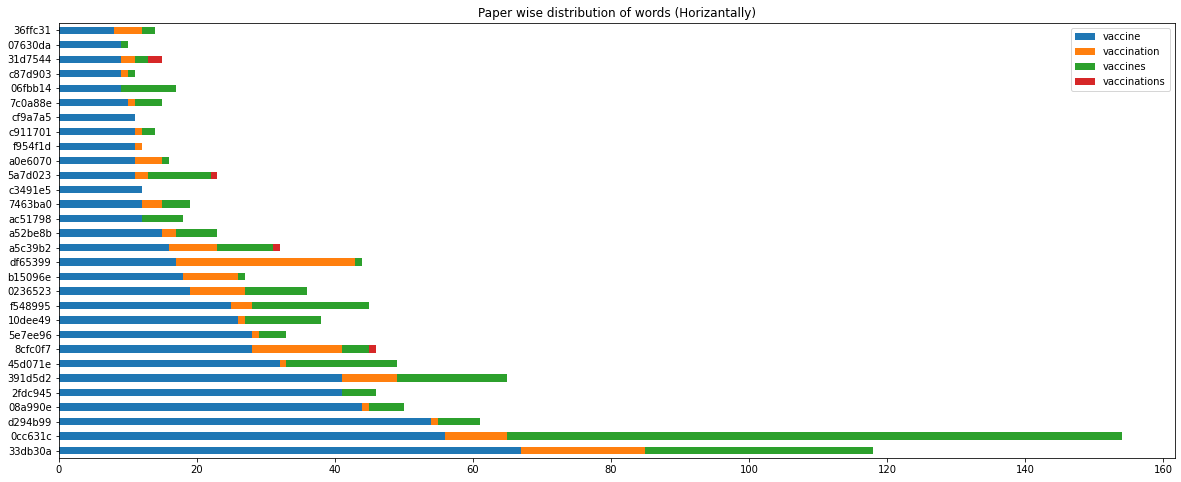

In [ ]:
targets = ['vaccine','vaccination','vaccines','vaccinations'] 
d={}
for line,paperid in df_sp.select("full_text","paper_id").toLocalIterator():
  c=countOccurences(line,targets,paperid)
  d.update(c)

df3=pd.DataFrame(d)
df3=df3.transpose()

temp_df=df3.sort_values(by=['vaccine'],ascending=False)
temp_df=temp_df.head(30)
#print(temp_df)
%matplotlib inline
temp_df.plot(kind='bar',x='paper_id',y='vaccine',figsize=(20,8),title='Top 30 papers for count of keyword: vaccine in Full Text')
temp_df.plot(kind='bar',figsize=(20,8),title='Paper wise distribution of words (Vertically)',stacked=True)
temp_df.plot.barh(figsize=(20,8),title='Paper wise distribution of words (Horizantally)',stacked=True)

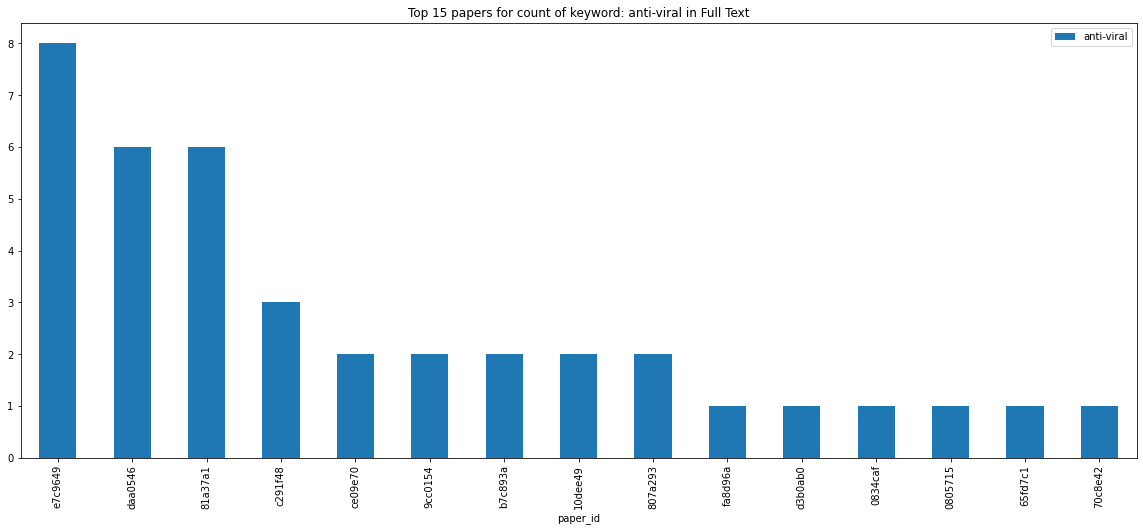

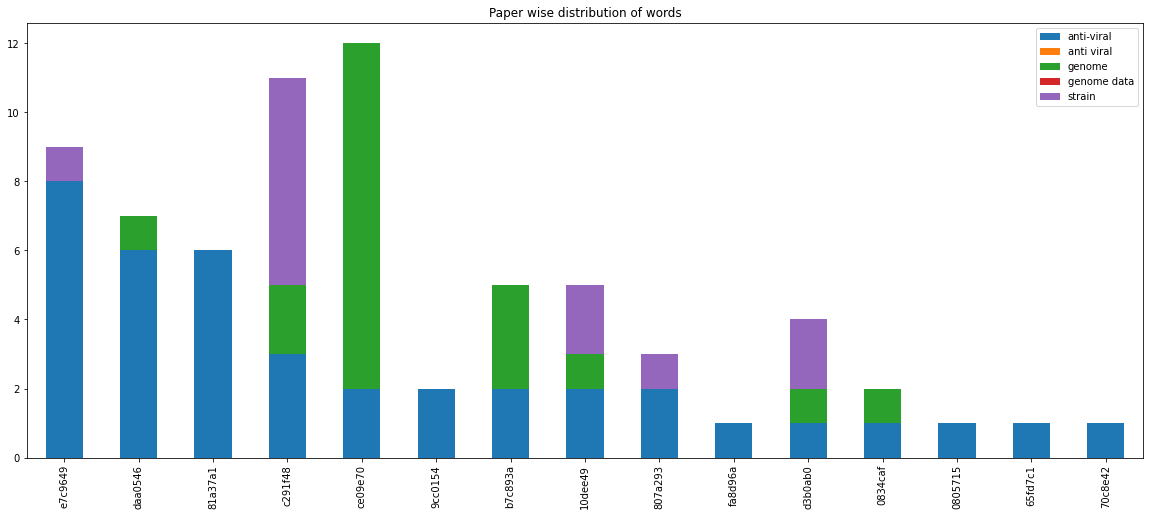

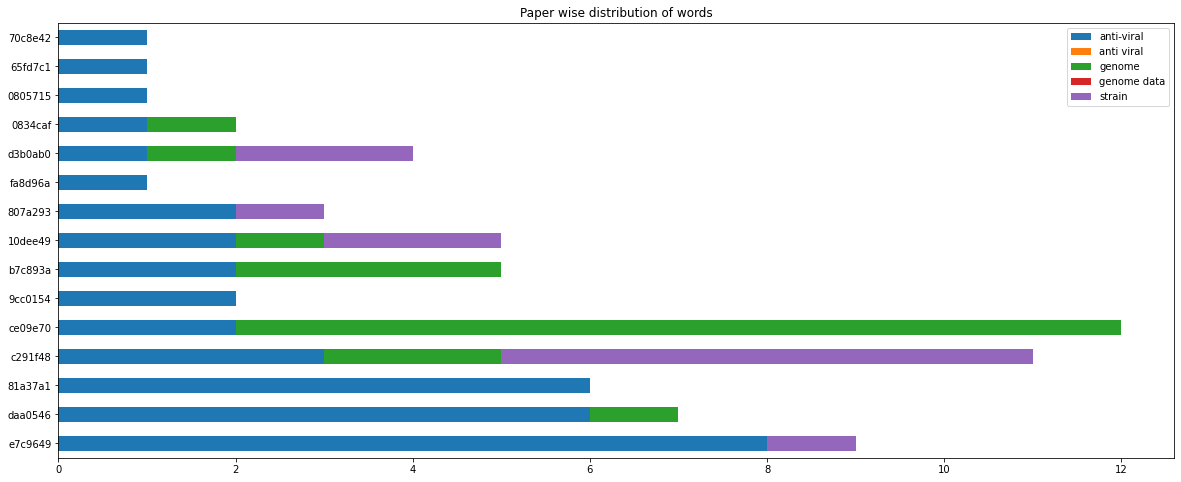

In [ ]:
targets = ['anti-viral','anti viral','genome','genome data','strain'] 
e={}
for line,paperid in df_sp.select("full_text","paper_id").toLocalIterator():
  f=countOccurences(str(line),targets,str(paperid))
  e.update(f)

df4=pd.DataFrame(e)
df4=df4.transpose()

temp_df=df4.sort_values(by=['anti-viral'],ascending=False)
temp_df=temp_df.head(15)

%matplotlib inline
temp_df.plot(kind='bar',x='paper_id',y='anti-viral',figsize=(20,8),title='Top 15 papers for count of keyword: anti-viral in Full Text')
temp_df.plot(kind='bar',figsize=(20,8),title='Paper wise distribution of words',stacked=True)
temp_df.plot.barh(figsize=(20,8),title='Paper wise distribution of words',stacked=True)


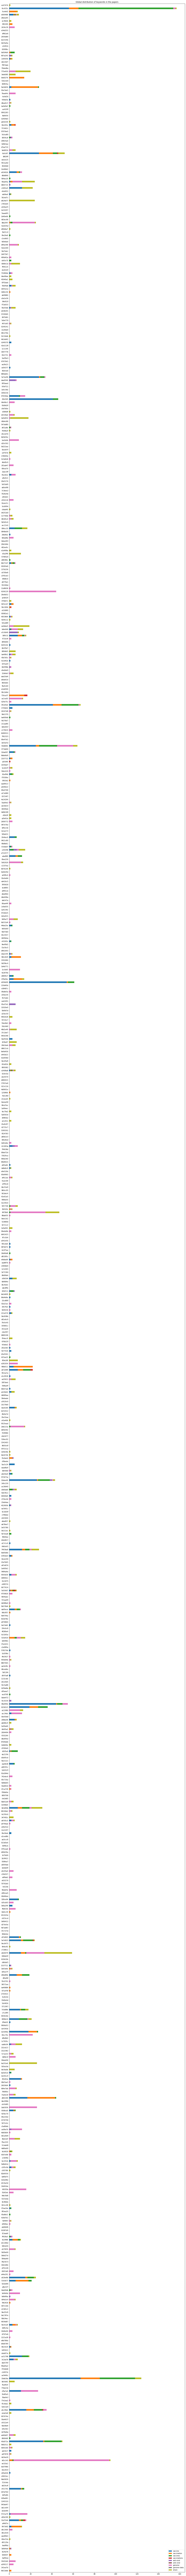

In [ ]:
targets = ['vaccine','vaccination','vaccines','vaccinations','anti-viral','anti viral','genome','genome data','strain'] 
g={}
for line,paperid in df_sp.select("full_text","paper_id").toLocalIterator():
  h=countOccurences(str(line),targets,str(paperid))
  g.update(h)
#print(g)
df5=pd.DataFrame(g)
df5=df5.transpose()

%matplotlib inline
df5.plot.barh(figsize=(20,300),title='Global distribution of keywords in the papers',stacked=True)

In [ ]:
def countOccurencesIgnoreKey(str, targets, paperkey):
  target=[]
  dictonary={}
  dictonary[paperkey] = {} 
  target=targets
  a=str.split(" ")
  count=0
  for targetword in target:
    for i in range(0,len(a)):
      if(targetword==a[i]):
        count=count+1
    #print(paperkey,count)
    #dictonary[paperkey]['paper_id']=paperkey
    dictonary[paperkey][targetword]=count
    #print(dictonary)
    count=0
  return dictonary

In [ ]:
targets=['Chile', 'Brazil', 'Iran', 'Canada', 'England', 'France', 'Colombia','turkey', 'Niger', 'China', 'Pakistan', 
         'India', 'Peru', 'USA', 'Russia', 'Mexico', 'South Africa', 'Spain', 'Argentina']
j={}
for line,paperid in df_sp.select("full_text","paper_id").toLocalIterator():
  i=countOccurencesIgnoreKey(str(line),targets,str(paperid))
  j.update(i)

df6=pd.DataFrame(j)
df6=df6.transpose()
CountryCount_df=df6.sum(axis = 0, skipna = True) 
#CountryCount_df=CountryCount_df.sort_values(ascending=False)
print(CountryCount_df)
CountryCount_Dict=CountryCount_df.to_dict()
Country_name=[]
Country_count=[]
for key in CountryCount_Dict.keys():
  Country_name.append(key)
for value in CountryCount_Dict.values():
  Country_count.append(value)


Chile            25
Brazil           45
Iran             37
Canada           33
England          39
France           77
Colombia          1
turkey           47
Niger            26
China           424
Pakistan         18
India           104
Peru              3
USA              88
Russia           12
Mexico           26
South Africa      0
Spain            72
Argentina         7
dtype: int64


([<matplotlib.patches.Wedge at 0x7fdb715cfeb8>,
 [Text(1.196851654125981, 0.08686839480445722, 'Chile'),
  Text(1.1548045751932199, 0.32623058273682265, 'Brazil'),
  Text(1.0455476189395827, 0.5889228952331271, 'Iran'),
  Text(0.9054486601510531, 0.7875041103579478, 'Canada'),
  Text(0.7226717151729241, 0.9579903924826303, 'England'),
  Text(0.3661867818676043, 1.1427629853934924, 'France'),
  Text(0.10073688298745236, 1.1957642244213413, 'Colombia'),
  Text(-0.06604437549024336, 1.1981811801501907, 'turkey'),
  Text(-0.31617799349091613, 1.1575972859470853, 'Niger'),
  Text(-1.1999999999999997, -1.931051837059921e-08, 'China'),
  Text(-0.34292968287919884, -1.1499561872525284, 'Pakistan'),
  Text(0.07645934424154768, -1.1975616763566512, 'India'),
  Text(0.43825513164659363, -1.1171089649561616, 'Peru'),
  Text(0.7143153570246293, -0.964237300003882, 'USA'),
  Text(0.9600808229707486, -0.7198922234361265, 'Russia'),
  Text(1.0333858208253264, -0.6100112665493698, 'Mexico'),
  Text(1.0

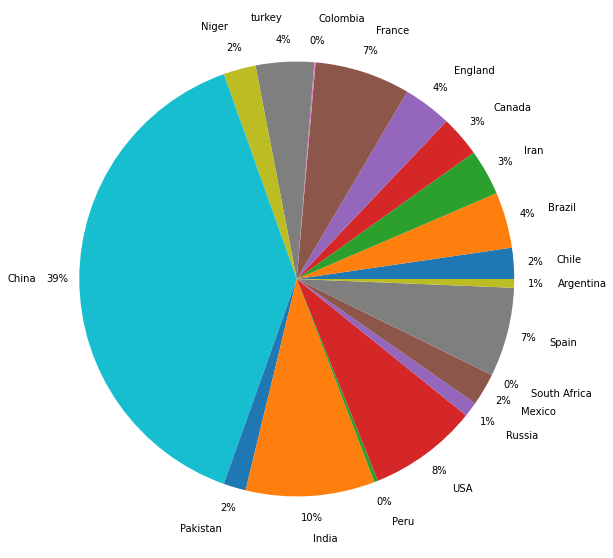

In [ ]:
%matplotlib inline
fig = plt.figure(figsize =(15, 10)) 
plt.pie(Country_count, labels = Country_name, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2) 

In [ ]:
#Add all the references in a single list and find the count of the repeats
bibs=[]
for item in df['bib_entries']:
    for eachbib in item:
        bibs.append(eachbib)
a = dict(Counter(bibs))
print(a)
#del a['']
df_a=pd.DataFrame.from_dict(a, orient='index',columns=['no. of times cited'])
df_a['no. of times cited'] = df_a['no. of times cited'].astype(str).astype(int)
sorted_df_a=df_a.sort_values(by='no. of times cited', ascending=False)
new_df = sorted_df_a.loc[sorted_df_a['no. of times cited'] >= 5] #5 here is the minimum no. of times the paper has been cited
new_df['title'] = new_df.index.str.slice(0,40)#truncated the title

{'Innovation médicales en situations humanitaires: le travail de Médecins Sans Frontières': 1, 'Conducting operational research within a non governmental organization: the example of Médecins Sans Frontières': 1, 'Research ethics review in humanitarian contexts: the experience of the independent ethics review board of Medecins Sans Frontieres': 2, 'What makes clinical research in developing countries ethical? The benchmarks of ethical research': 1, 'MSF Field research': 1, 'World Medical Association Declaration of Helsinki. Ethical Principles for Medical Research Involving Human Subjects': 3, 'Council for International Organizations of Medical Sciences (CIOMS) in collaboration with the World Health Organization (WHO)': 3, 'Theory and practice in public health ethics: a complex relationship': 1, "Relief of oppression': an organizing principle for researchers' obligations to participants in observational studies in the developing world": 1, 'A framework for ethics review during public em

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


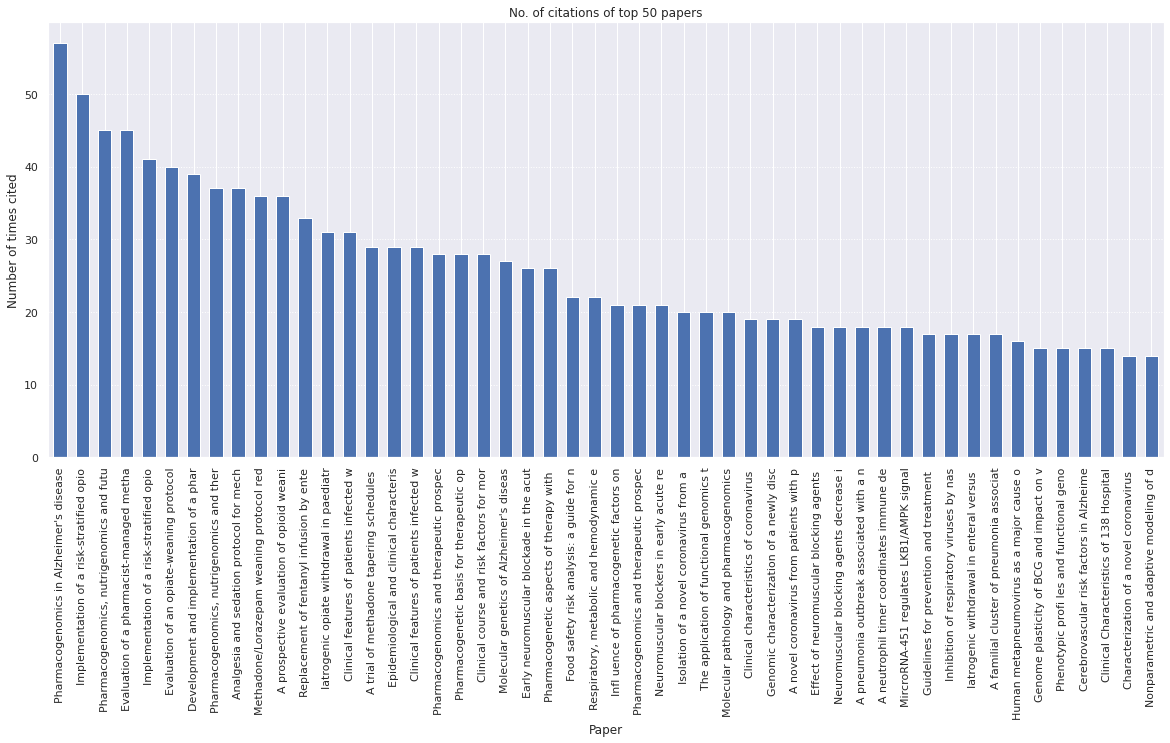

In [ ]:
#Getting Seaborn Style for Pandas Plots
top_n=50
sns.set()       
new_df[0:top_n].reset_index().plot(
    x = 'title', 
    y = 'no. of times cited', 
    kind='bar', 
    legend = False,
    width=0.6,
    figsize=(20,8)
)
plt.ylabel("Number of times cited")
plt.xlabel("Paper")
plt.title("No. of citations of top "+format(top_n)+" papers")
plt.gca().yaxis.grid(linestyle=':')

In [ ]:
#pip install export_saved_model

In [ ]:
spark.stop()